In [35]:
import pandas as pd
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from sklearn.linear_model import LinearRegression
from pathlib import Path

In [36]:
# Condição que habilita os anos que podemos utilizar (Range)
anos_range = [str(ano) for ano in range(2009, 2025)]

anos = []

for ano in anos_range:
    anos.extend([ano, f"{ano}.1"])


In [37]:
# Função para realizar a limpeza de caracteres especiais e acentuações na coluna de país
def limpa_acentuacoes(texto):
  texto_sem_acentos = unidecode(texto)

  texto_limpo = re.sub(r'[^\w\s]', '', texto_sem_acentos)

  return texto_limpo

# Função para corrigir os países
correcoes_paises = {
    'Alemanha Republica Democratica':    'Alemanha',
    'Barein':                             'Bahrein',
    'Belice':                             'Belize',
    'BosniaHerzegovina':                  'Bosnia e Herzegovina',
    'Cayman Ilhas':                       'Ilhas Cayman',
    'Cocos Keeling Ilhas':                'Ilhas Cocos Keeling',
    'Coreia Republica Sul':               'Coreia do Sul',
    'Coveite Kuweit':                     'Kuwait',
    'Eslovaca, Republica':                'Eslovaquia',
    'Tcheca Republica':                   'Republica Tcheca',
    'Trinidade Tobago':                   'Trindade e Tobago',
    'Malavi':                             'MalaWi'
}

In [38]:
base_path = Path.cwd()

if base_path.name == 'notebooks':
    path_data = base_path.parent / 'data'
else:
    path_data = base_path / 'data'

print(f"Buscando arquivos em: {path_data}")

Exp_de_Vinho_de_Mesa = pd.read_csv(path_data / 'Exp_de_Vinho_de_Mesa.csv', encoding='utf-8', sep='\t')
Exp_de_Espumantes    = pd.read_csv(path_data / 'Exp_de_Espumantes.csv', encoding='utf-8', sep='\t')
Exp_de_Uvas_Frescas  = pd.read_csv(path_data / 'Exp_de_Uvas_Frescas.csv', encoding='utf-8', sep='\t')
Exp_de_Suco_de_Uva   = pd.read_csv(path_data / 'Exp_de_Suco_de_Uva.csv', encoding='utf-8', sep='\t')

Buscando arquivos em: g:\Meu Drive\FIAP\Tech Challenge 1\Brazil_Wine_Exports_Analysis\data


In [39]:
# Criando coluna para classificar o tipo de produto
Exp_de_Vinho_de_Mesa['Tipo_Produto'] = 'Vinho de Mesa'
Exp_de_Espumantes['Tipo_Produto'] = 'Espumante'
Exp_de_Uvas_Frescas['Tipo_Produto'] = 'Uvas Frescas'
Exp_de_Suco_de_Uva['Tipo_Produto'] = 'Suco de Uva'

In [40]:
lista_dfs = [Exp_de_Vinho_de_Mesa, Exp_de_Espumantes, Exp_de_Uvas_Frescas, Exp_de_Suco_de_Uva]
df_unificado = pd.concat(lista_dfs)

In [41]:
# Tratamento do arquivo considerando a condição do range
df_unificado = df_unificado.loc[:, ['Id', 'País', 'Tipo_Produto'] + anos]

# Realiza a limpeza da coluna país
df_unificado['País'] = df_unificado['País'].apply(limpa_acentuacoes)

# Realiza a conversao das colunas de 2009 para Quantidade e 2009.1 para Valor, assim com os demais anos
df_unificado = pd.melt(df_unificado, id_vars=['Id', 'País', 'Tipo_Produto'], value_vars=[col for col in df_unificado.columns if col not in ['Id', 'País', 'Tipo_Produto']],
                                 var_name='Ano_Tipo', value_name='Valor_Quantidade')

df_unificado['Tipo'] = df_unificado['Ano_Tipo'].apply(lambda x: 'Quantidade' if '.1' not in x else 'Valor')

df_unificado['Ano'] = df_unificado['Ano_Tipo'].apply(lambda x: x.split('.')[0])

df_unificado = df_unificado.drop(columns=['Ano_Tipo'])

df_unificado = df_unificado.pivot_table(index=['Id', 'País', 'Ano', 'Tipo_Produto'], columns ='Tipo', values='Valor_Quantidade', aggfunc='first').reset_index()

In [42]:
# Aplica as correções aos nomes dos países no DataFrame unificado
df_unificado['País'] = df_unificado['País'].replace(correcoes_paises)
df_unificado['Ano'] = pd.to_datetime(df_unificado['Ano'], format="%Y", errors="coerce").dt.year

In [43]:
# Remove os pontos de milhar e converte para float
df_unificado['Valor'] = (
    df_unificado['Valor']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

df_unificado['Quantidade'] = (
    df_unificado['Quantidade']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

In [44]:
# Filtrar apenas para o produto "Vinho de Mesa"
df_vinho_mesa = df_unificado[df_unificado["Tipo_Produto"] == "Vinho de Mesa"]

# Agrupar por país e somar quantidade e valor
resumo_mesa = df_vinho_mesa.groupby("País")[["Quantidade", "Valor"]].sum().reset_index()

# Calcular totais gerais
total_quantidade_mesa = resumo_mesa["Quantidade"].sum()
total_valor_mesa = resumo_mesa["Valor"].sum()

# Adicionar colunas de percentuais
resumo_mesa["% Quantidade"] = (resumo_mesa["Quantidade"] / total_quantidade_mesa) * 100
resumo_mesa["% Valor"] = (resumo_mesa["Valor"] / total_valor_mesa) * 100

# Ordenar pelo valor
resumo_mesa = resumo_mesa.sort_values(by="Valor", ascending=False).reset_index(drop=True)

resumo_mesa.head(5)


Tipo,País,Quantidade,Valor,% Quantidade,% Valor
0,Paraguai,34508515.0,47984063.0,38.992909,38.947924
1,Russia,32822197.0,23152054.0,37.087454,18.792165
2,Estados Unidos,3659709.0,9957775.0,4.135290,8.082572
3,China,2608917.0,5086290.0,2.947947,4.128463
4,Reino Unido,1165560.0,4747648.0,1.317025,3.853593


In [45]:
output_path = base_path / 'outputs'
output_path.mkdir(exist_ok=True)

# Salvar o arquivo dentro da pasta
df_unificado.to_excel(output_path / 'df_anos_totais.xlsx', index=False)

In [46]:
# Filtro por produto
produto_desejado = "Vinho de Mesa"
filtro_produto = df_unificado[df_unificado["Tipo_Produto"] == produto_desejado]

# Calcula o valor total por país e pega os top 5
top5_paises_valor_total = filtro_produto.groupby('País')['Valor'].sum().nlargest(5).index.tolist()

# Filtra os dados para conter apenas os top 5 países
df_top5_teste = filtro_produto[filtro_produto["País"].isin(top5_paises_valor_total)]

# Para cada ano, pega o país com maior valor (dentre os top 5 globais)
top1_por_ano = df_top5_teste.sort_values(['Ano', 'Valor'], ascending=[True, False]).groupby('Ano').head(1)

In [47]:
top1_por_ano

Tipo,Id,País,Ano,Tipo_Produto,Quantidade,Valor
7232,116,Russia,2009,Vinho de Mesa,21912914.0,5732280.0
3329,53,Estados Unidos,2010,Vinho de Mesa,228968.0,478630.0
3330,53,Estados Unidos,2011,Vinho de Mesa,306787.0,1030254.0
7235,116,Russia,2012,Vinho de Mesa,4528176.0,2103968.0
7236,116,Russia,2013,Vinho de Mesa,5893291.0,14795694.0
7141,114,Reino Unido,2014,Vinho de Mesa,305807.0,1373747.0
6806,107,Paraguai,2015,Vinho de Mesa,495428.0,741370.0
6807,107,Paraguai,2016,Vinho de Mesa,985739.0,1655417.0
6808,107,Paraguai,2017,Vinho de Mesa,2393468.0,4274650.0
6809,107,Paraguai,2018,Vinho de Mesa,3234168.0,5494321.0


c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


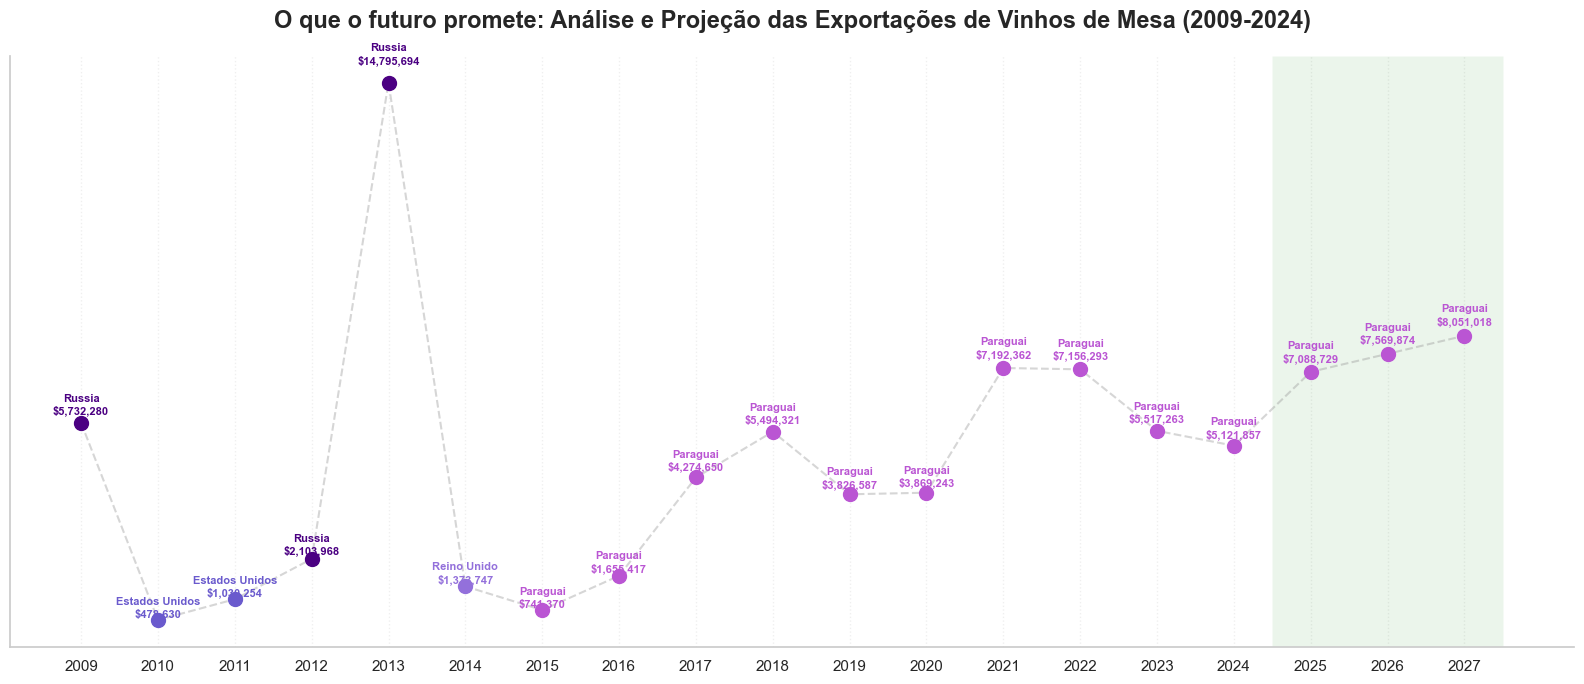

In [48]:
# Filtra somente vinho de mesa
df_vinho = df_unificado[df_unificado['Tipo_Produto'] == 'Vinho de Mesa']

# Top 1 real por ano (2009 a 2024)
historico_top1 = (
    df_vinho[df_vinho['Ano'].between(2009, 2024)]
    .sort_values(['Ano', 'Valor'], ascending=[True, False])
    .drop_duplicates('Ano')
)

# Faz projeções só dos países que já foram Top 1
projecoes_top1 = []

for pais in historico_top1['País'].unique():
    df_pais = df_vinho[(df_vinho['País'] == pais) & (df_vinho['Ano'].between(2009, 2024))]
    if len(df_pais) >= 3:
        X = df_pais['Ano'].values.reshape(-1, 1)
        y = df_pais['Valor'].values
        model = LinearRegression()
        model.fit(X, y)
        anos_futuros = pd.DataFrame({'Ano': [2025, 2026, 2027]})
        y_pred = model.predict(anos_futuros)
        proj = pd.DataFrame({
            'Ano': anos_futuros['Ano'],
            'País': pais,
            'Valor': y_pred.astype(int)
        })
        projecoes_top1.append(proj)

# Junta histórico + projeções
df_proj = pd.concat(projecoes_top1, ignore_index=True)
df_top1 = pd.concat([historico_top1[['Ano', 'País', 'Valor']], df_proj], ignore_index=True)

# Seleciona o Top 1 verdadeiro por ano (histórico + previsão)
top1_por_ano = df_top1.sort_values(['Ano', 'Valor'], ascending=[True, False]).drop_duplicates('Ano')

# Paleta personalizada
cores_gradiente = ["#4B0082", "#6A5ACD", "#9370DB", "#BA55D3", "#DA70D6"]
paises_unicos = top1_por_ano['País'].unique()
cores_paises_custom = dict(zip(paises_unicos, cores_gradiente))
cores = top1_por_ano['País'].map(cores_paises_custom)

# Criação do gráfico
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16, 7))

# Adiciona fundo verde claro para área de projeção (2025 em diante)
ax.axvspan(2024.5, 2027.5, facecolor='green', alpha=0.08)

# Linha base
ax.plot(top1_por_ano['Ano'], top1_por_ano['Valor'],
        color="#999999", linewidth=1.5, linestyle='--', alpha=0.4)

# Pontos e rótulos
for i, row in top1_por_ano.iterrows():
    ax.plot(row['Ano'], row['Valor'], marker='o', markersize=10, color=cores[i])
    ax.text(row['Ano'], row['Valor'] * 1.03,
            f"{row['País']}\n${row['Valor']:,.0f}",
            ha='center', va='bottom', fontsize=8, fontweight='bold', color=cores[i])

# Layout
ax.set_title('O que o futuro promete: Análise e Projeção das Exportações de Vinhos de Mesa (2009-2024)', fontsize=17, weight='bold', pad=20)
ax.set_ylabel('Valor Total Exportado (US$)', fontsize=13)
ax.grid(axis='y', linestyle=':', alpha=0.1)
ax.grid(axis='x', linestyle=':', alpha=0.3)
ax.yaxis.set_visible(False)
ax.set_xticks(top1_por_ano['Ano'])
ax.set_xticklabels(top1_por_ano['Ano'], rotation=0, fontsize=11)
sns.despine()

plt.tight_layout()
plt.show()

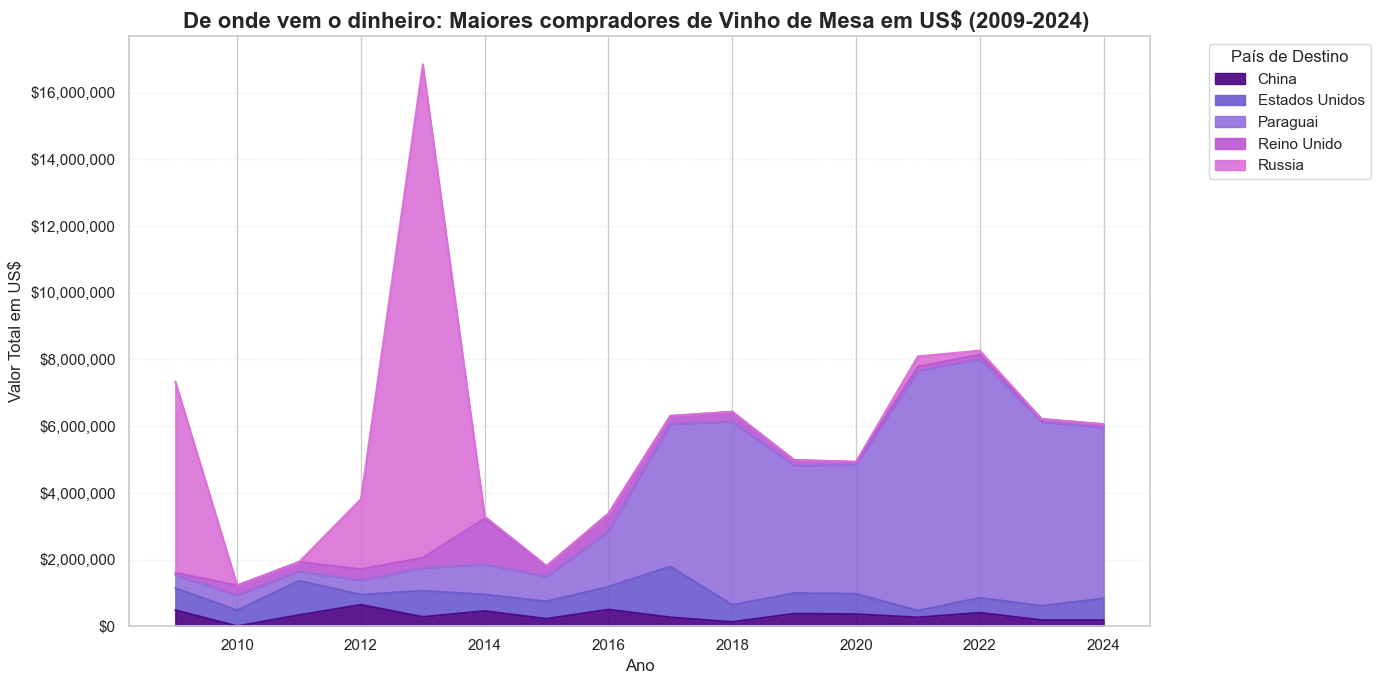

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Paleta gradiente personalizada (tons modernos de púrpura, azul e rosa)
cores_gradiente = [
    "#4B0082",  # índigo
    "#6A5ACD",  # azul violeta
    "#9370DB",  # roxo médio
    "#BA55D3",  # orquídea escura
    "#DA70D6"   # orquídea média
]

# Filtro por produto
produto_desejado = "Vinho de Mesa"
filtro_produto = df_unificado[df_unificado["Tipo_Produto"] == produto_desejado]

# Top 5 países com maior valor total para esse produto
top_paises = filtro_produto.groupby("País")["Valor"].sum().nlargest(5).index

# Filtra novamente para manter só os top 5
df_top5 = filtro_produto[filtro_produto["País"].isin(top_paises)]

# Agrupa por Ano e País e soma o Valor
df_final_top = df_top5.groupby(["Ano", "País"])["Valor"].sum().unstack() # Corrected line
df_final_top = df_final_top.sort_index()

# Cria o gráfico
fig, ax = plt.subplots(figsize=(14, 7))
df_final_top.plot(kind="area", stacked=True, alpha=0.9, ax=ax, color=cores_gradiente)

# Estilizando
ax.set_title(f"De onde vem o dinheiro: Maiores compradores de {produto_desejado} em US$ (2009-2024) ", fontsize=16, weight='bold')
ax.set_xlabel("Ano", fontsize=12)
ax.set_ylabel("Valor Total em US$", fontsize=12)
ax.legend(title="País de Destino", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis='y', linestyle=':', alpha=0.4)

# Formatando o eixo Y
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [50]:
df_final_top

País,China,Estados Unidos,Paraguai,Reino Unido,Russia
Ano,,,,,
2009,482400.0,660066.0,392087.0,68788.0,5732280.0
2010,2358.0,478630.0,449197.0,295690.0,0.0
2011,334867.0,1030254.0,276281.0,285642.0,0.0
2012,642177.0,303986.0,428279.0,334856.0,2103968.0
2013,279956.0,786556.0,680828.0,305005.0,14795694.0
2014,455340.0,494216.0,908028.0,1373747.0,61440.0
2015,222866.0,524109.0,741370.0,308407.0,18240.0
2016,499622.0,687411.0,1655417.0,536681.0,0.0
2017,266086.0,1523699.0,4274650.0,242883.0,0.0


C:\Users\Pedro\AppData\Local\Temp\ipykernel_22020\4178144917.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_paises, x='Quantidade', y='País', palette=cores_gradiente)


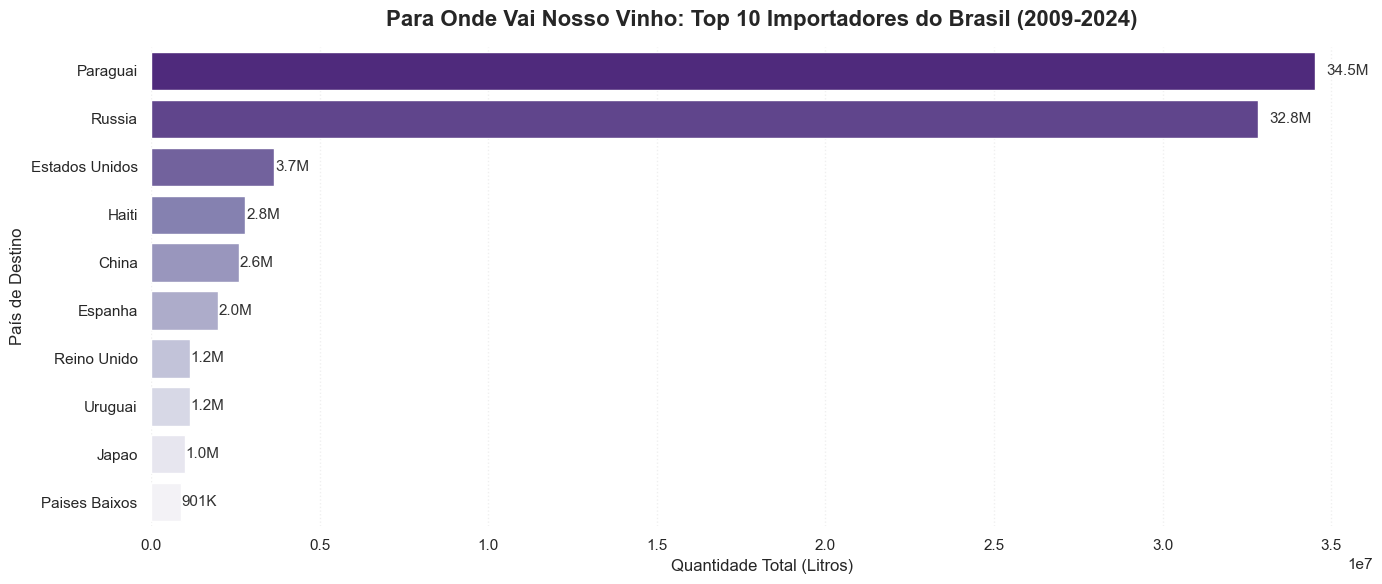

In [51]:
# Paleta azul invertida (maior valor = azul mais claro)
cores_gradiente = sns.color_palette("Purples", n_colors=10)
cores_gradiente.reverse()

# Função para formatar valores
def formatar_valor(valor):
    if valor >= 1_000_000:
        return f"{valor/1_000_000:.1f}M"
    elif valor >= 1_000:
        return f"{valor/1_000:.0f}K"
    else:
        return str(valor)

# Filtro por produto
produto_desejado = "Vinho de Mesa"
filtro_produto = df_unificado[df_unificado["Tipo_Produto"] == produto_desejado]

# Agrupa e pega os 10 maiores
top_paises = filtro_produto.groupby("País")["Quantidade"].sum().reset_index()
top_paises = top_paises.sort_values('Quantidade', ascending=False).head(10)

# Gráfico
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=top_paises, x='Quantidade', y='País', palette=cores_gradiente)

# Rótulos com valor formatado
for i, valor in enumerate(top_paises['Quantidade']):
    ax.text(valor + (valor * 0.01), i, formatar_valor(valor), va='center', fontsize=11, color='#333333')

# Estilo do gráfico
ax.set_title('Para Onde Vai Nosso Vinho: Top 10 Importadores do Brasil (2009-2024)', fontsize=16, pad=15, weight='bold')
ax.set_xlabel('Quantidade Total (Litros)', fontsize=12)
ax.set_ylabel('País de Destino', fontsize=12)
ax.grid(axis='x', linestyle=':', alpha=0.3)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [56]:
output_path = base_path / 'outputs'
output_path.mkdir(exist_ok=True)

# Salvar o arquivo dentro da pasta
df_final_top.to_excel(output_path / 'df_final_top.xlsx', index=False)

In [53]:
top_paises

,País,Quantidade
106,Paraguai,34508515.0
116,Russia,32822197.0
49,Estados Unidos,3659709.0
64,Haiti,2801918.0
30,China,2608917.0
48,Espanha,1990429.0
113,Reino Unido,1165560.0
137,Uruguai,1155417.0
79,Japao,1001661.0
103,Paises Baixos,901060.0


In [54]:
df_final_top = df_final_top.sort_index()
df_final_top.head()
valor_medio_chi = df_final_top['China'].mean()
valor_medio_eua = df_final_top['Estados Unidos'].mean()
valor_medio_par = df_final_top['Paraguai'].mean()
valor_medio_run = df_final_top['Reino Unido'].mean()
valor_medio_rus = df_final_top['Russia'].mean()

valor_medio = (valor_medio_chi + valor_medio_eua + valor_medio_par + valor_medio_run + valor_medio_rus)/5
valor_medio

from IPython.display import display, HTML

# Formatar o valor para exibição
valor_formatado = f"${valor_medio:,.2f}"

# Criar a estrutura HTML para a label gráfica
html_kpi = f"""
<div style="
    border: 1px solid #ccc;
    padding: 15px;
    margin: 10px;
    border-radius: 5px;
    background-color: #f9f9f9;
    width: 200px;
    text-align: center;
    box-shadow: 2px 2px 5px #888888;
">
    <div style="font-size: 12px; color: #555;">Valor Médio</div>
    <div style="font-size: 24px; font-weight: bold; color: #333;">{valor_formatado}</div>
</div>
"""

# Exibir o HTML
display(HTML(html_kpi))

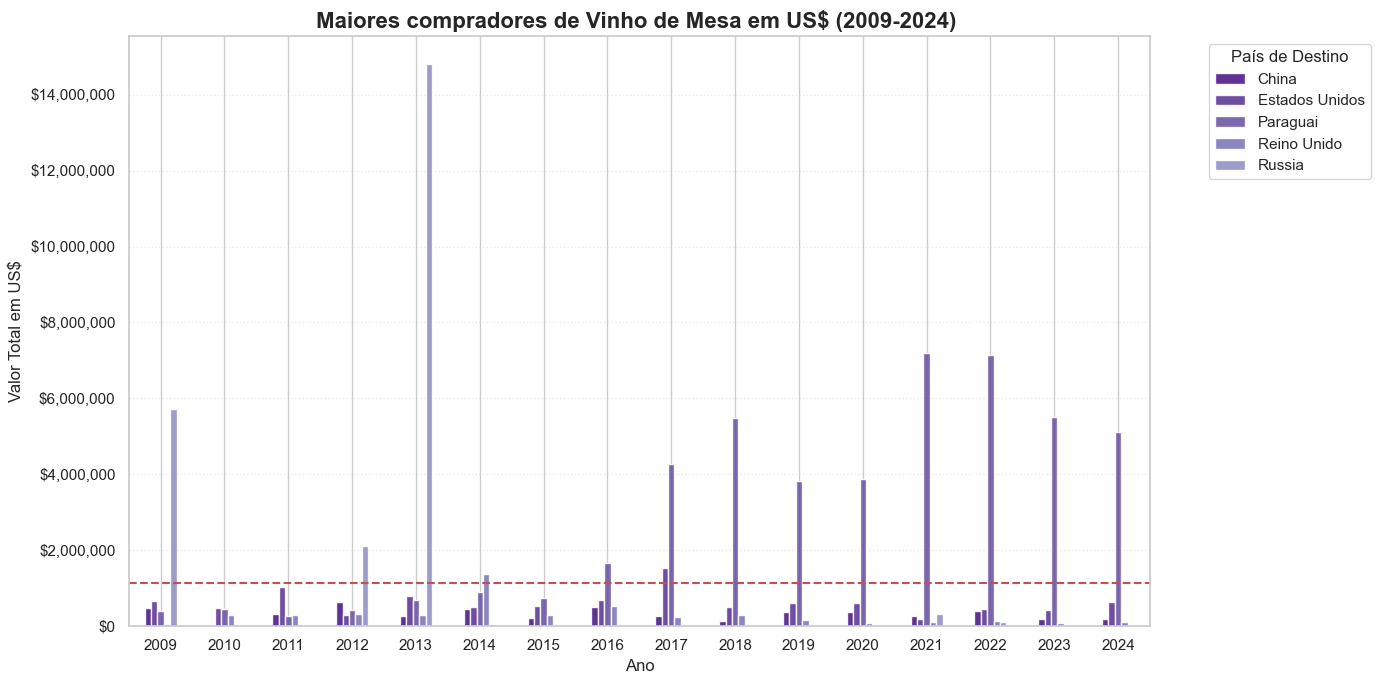

In [55]:
# Cria o gráfico
fig, ax = plt.subplots(figsize=(14, 7))
df_final_top.plot(kind="bar",  alpha=0.9, ax=ax, color=cores_gradiente)

# Estilizando
ax.set_title(f"Maiores compradores de {produto_desejado} em US$ (2009-2024) ", fontsize=16, weight='bold')
ax.set_xlabel("Ano", fontsize=12)
ax.set_ylabel("Valor Total em US$", fontsize=12)
ax.legend(title="País de Destino", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis='y', linestyle=':', alpha=0.4)


plt.axhline(y=valor_medio, color='r', linestyle='--', label=f'Média: {valor_medio:.2f}')
#plt.text(x_pos, valor_medio, f'Valor médio: {valor_medio:.2f}', color='r', va='center', ha='right', backgroundcolor='white')

# Formatando o eixo Y
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()